In [2]:
import pandas as pd

# load the accounts data from the raw folder
df_accounts = pd.read_csv("../data/raw/ravenstack_accounts.csv")

# verify the data was loaded correctly
df_accounts.head()

,account_id,account_name,industry,country,signup_date,referral_source,plan_tier,seats,is_trial,churn_flag
0,A-2e4581,Company_0,EdTech,US,2024-10-16,partner,Basic,9,False,False
1,A-43a9e3,Company_1,FinTech,IN,2023-08-17,other,Basic,18,False,True
2,A-0a282f,Company_2,DevTools,US,2024-08-27,organic,Basic,1,False,False
3,A-1f0ac7,Company_3,HealthTech,UK,2023-08-27,other,Basic,24,True,False
4,A-ce550d,Company_4,HealthTech,US,2024-10-27,event,Enterprise,35,False,True


In [3]:
print("--- Referral Sources ---")
print(df_accounts['referral_source'].value_counts(dropna=False))

print("\n--- Industries ---")
print(df_accounts['industry'].value_counts(dropna=False))

print("\n--- Plan Tiers ---")
print(df_accounts['plan_tier'].value_counts(dropna=False))

--- Referral Sources ---
referral_source
organic    114
other      103
ads         98
event       96
partner     89
Name: count, dtype: int64

--- Industries ---
industry
DevTools         113
FinTech          112
Cybersecurity    100
HealthTech        96
EdTech            79
Name: count, dtype: int64

--- Plan Tiers ---
plan_tier
Pro           178
Basic         168
Enterprise    154
Name: count, dtype: int64


In [4]:
# Check temporal boundaries and data types
print("--- Signup Dates ---")
print(f"Data Type: {df_accounts['signup_date'].dtype}")
print(f"Missing Values: {df_accounts['signup_date'].isna().sum()}")
print(f"Earliest Signup: {df_accounts['signup_date'].min()}")
print(f"Latest Signup: {df_accounts['signup_date'].max()}")

print("\n--- Seats Distribution ---")
print(df_accounts['seats'].describe())

--- Signup Dates ---
Data Type: str
Missing Values: 0
Earliest Signup: 2023-01-02
Latest Signup: 2024-12-31

--- Seats Distribution ---
count    500.000000
mean      20.560000
std       21.044718
min        1.000000
25%        5.000000
50%       15.000000
75%       28.000000
max      163.000000
Name: seats, dtype: float64


In [5]:
# 1. Cast string to datetime
df_accounts['signup_date'] = pd.to_datetime(df_accounts['signup_date'])

# 2. Cast float to integer
df_accounts['seats'] = df_accounts['seats'].astype(int)

# 3. Verify the changes
print(df_accounts[['signup_date', 'seats']].dtypes)

# 4. Save to the processed tier
df_accounts.to_csv('../data/processed/dim_accounts.csv', index=False)
print("\nSuccess: dim_accounts.csv saved to processed folder.")

signup_date    datetime64[us]
seats                   int64
dtype: object

Success: dim_accounts.csv saved to processed folder.


In [6]:
# Load subscriptions
df_subs = pd.read_csv('../data/raw/ravenstack_subscriptions.csv')

# Interrogate Categoricals
print("--- Plan Tiers ---")
print(df_subs['plan_tier'].value_counts(dropna=False))

print("\n--- Billing Frequencies ---")
print(df_subs['billing_frequency'].value_counts(dropna=False))

# Interrogate Temporal & Financials
print("\n--- End Date Nulls (Active Subs) ---")
print(f"Missing End Dates: {df_subs['end_date'].isna().sum()}")

print("\n--- MRR Summary ---")
print(df_subs['mrr_amount'].describe())

--- Plan Tiers ---
plan_tier
Enterprise    1723
Pro           1675
Basic         1602
Name: count, dtype: int64

--- Billing Frequencies ---
billing_frequency
monthly    2539
annual     2461
Name: count, dtype: int64

--- End Date Nulls (Active Subs) ---
Missing End Dates: 4514

--- MRR Summary ---
count     5000.000000
mean      2267.749400
std       3421.375348
min          0.000000
25%        285.000000
50%        931.000000
75%       2786.000000
max      33830.000000
Name: mrr_amount, dtype: float64


--- Investigating $0 MRR ---
Total $0 MRR records: 778
Are these trials?
is_trial
True    778
Name: count, dtype: int64


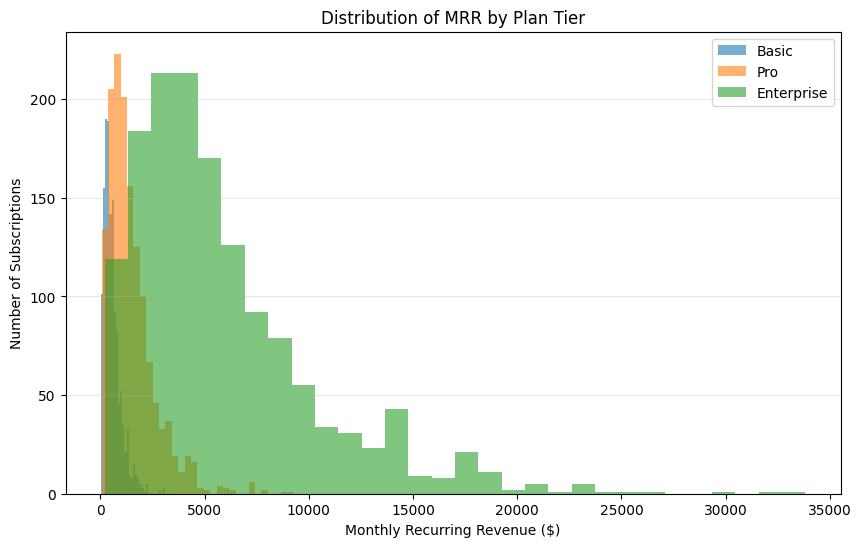

In [7]:
import matplotlib.pyplot as plt

# 1. Cast strings to datetimes
df_subs['start_date'] = pd.to_datetime(df_subs['start_date'])
df_subs['end_date'] = pd.to_datetime(df_subs['end_date'])

# 2. Interrogate the Zero MRR anomaly
zero_mrr = df_subs[df_subs['mrr_amount'] == 0]
print("--- Investigating $0 MRR ---")
print(f"Total $0 MRR records: {len(zero_mrr)}")
print("Are these trials?")
print(zero_mrr['is_trial'].value_counts(dropna=False))

# 3. Visual EDA: MRR Distribution by Plan Tier (Excluding $0 Trials)
plt.figure(figsize=(10, 6))
active_paid = df_subs[df_subs['mrr_amount'] > 0]

for tier in ['Basic', 'Pro', 'Enterprise']:
    subset = active_paid[active_paid['plan_tier'] == tier]
    plt.hist(subset['mrr_amount'], bins=30, alpha=0.6, label=tier)

plt.title('Distribution of MRR by Plan Tier')
plt.xlabel('Monthly Recurring Revenue ($)')
plt.ylabel('Number of Subscriptions')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

# 4. Save clean data
df_subs.to_csv('../data/processed/fact_subscriptions.csv', index=False)

In [8]:
# 1. Load the event telemetry data
df_features = pd.read_csv('../data/raw/ravenstack_feature_usage.csv')

print("--- Data Shape & Memory ---")
print(df_features.info())

print("\n--- Telemetry Anomalies (Nulls) ---")
print(df_features.isnull().sum())

print("\n--- Feature Name Cardinality ---")
print(f"Total Unique Features: {df_features['feature_name'].nunique()}")
print(df_features['feature_name'].value_counts().head(10)) # Let's peek at the top 10

print("\n--- Numeric Boundaries ---")
print(df_features[['usage_count', 'usage_duration_secs', 'error_count']].describe())

--- Data Shape & Memory ---
<class 'pandas.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   usage_id             25000 non-null  str  
 1   subscription_id      25000 non-null  str  
 2   usage_date           25000 non-null  str  
 3   feature_name         25000 non-null  str  
 4   usage_count          25000 non-null  int64
 5   usage_duration_secs  25000 non-null  int64
 6   error_count          25000 non-null  int64
 7   is_beta_feature      25000 non-null  bool 
dtypes: bool(1), int64(3), str(4)
memory usage: 1.4 MB
None

--- Telemetry Anomalies (Nulls) ---
usage_id               0
subscription_id        0
usage_date             0
feature_name           0
usage_count            0
usage_duration_secs    0
error_count            0
is_beta_feature        0
dtype: int64

--- Feature Name Cardinality ---
Total Unique Features: 40
feature_name
feature_12  

In [9]:
# 1. Cast string to datetime
df_features['usage_date'] = pd.to_datetime(df_features['usage_date'])

# 2. Verify data type
print(f"New usage_date dtype: {df_features['usage_date'].dtype}")

# 3. Save to the processed tier as a Fact table
df_features.to_csv('../data/processed/fact_feature_usage.csv', index=False)
print("Success: fact_feature_usage.csv saved to processed folder.")

New usage_date dtype: datetime64[us]
Success: fact_feature_usage.csv saved to processed folder.


In [10]:
# Load final two tables
df_support = pd.read_csv('../data/raw/ravenstack_support_tickets.csv')
df_churn = pd.read_csv('../data/raw/ravenstack_churn_events.csv')

print("--- Support Tickets: Temporal Boundaries & Nulls ---")
print(f"Missing Close Dates: {df_support['closed_at'].isna().sum()}")
print(f"Missing Satisfaction Scores: {df_support['satisfaction_score'].isna().sum()}")

print("\n--- Support Tickets: Resolution Time ---")
print(df_support['resolution_time_hours'].describe())

print("\n--- Churn Events: Reason Codes ---")
print(df_churn['reason_code'].value_counts(dropna=False))

print("\n--- Churn Events: Refunds ---")
print(df_churn['refund_amount_usd'].describe())

--- Support Tickets: Temporal Boundaries & Nulls ---
Missing Close Dates: 0
Missing Satisfaction Scores: 825

--- Support Tickets: Resolution Time ---
count    2000.000000
mean       35.861000
std        21.138427
min         1.000000
25%        17.000000
50%        35.000000
75%        54.000000
max        72.000000
Name: resolution_time_hours, dtype: float64

--- Churn Events: Reason Codes ---
reason_code
features      114
support       104
budget        104
unknown        95
competitor     92
pricing        91
Name: count, dtype: int64

--- Churn Events: Refunds ---
count    600.000000
mean      14.420417
std       39.224591
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max      392.920000
Name: refund_amount_usd, dtype: float64


In [11]:
# 1. Cast Support Ticket dates
df_support['submitted_at'] = pd.to_datetime(df_support['submitted_at'])
df_support['closed_at'] = pd.to_datetime(df_support['closed_at'])

# 2. Cast Churn dates
df_churn['churn_date'] = pd.to_datetime(df_churn['churn_date'])

# 3. Save to the processed tier
df_support.to_csv('../data/processed/fact_support_tickets.csv', index=False)
df_churn.to_csv('../data/processed/fact_churn_events.csv', index=False)

print("Success: Final fact tables saved to processed folder.")

Success: Final fact tables saved to processed folder.


In [12]:
# 1. How many total rows exist?
total_events = len(df_features)

# 2. How many rows had AT LEAST one error?
events_with_errors = len(df_features[df_features['error_count'] > 0])

# 3. What is the actual failure rate?
actual_error_rate = (events_with_errors / total_events) * 100

print(f"Total Events: {total_events}")
print(f"Events with 1+ errors: {events_with_errors}")
print(f"Actual Session Error Rate: {actual_error_rate:.2f}%")

Total Events: 25000
Events with 1+ errors: 7731
Actual Session Error Rate: 30.92%
